In [18]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import numpy as np

# Загрузка данных
deals_df = pd.read_pickle('deals_cleaned.pkl')
contacts_df = pd.read_pickle('contacts_cleaned.pkl')
spend_df = pd.read_pickle('spend_cleaned.pkl')
metrics_df = pd.read_pickle('metrics.pkl')
calls_df = pd.read_pickle("calls_cleaned.pkl")


In [2]:
leads = contacts_df['Id'].nunique()
contact_all_deals = deals_df['Contact Name'].nunique()
success_contacts = deals_df[(deals_df['Stage'] == 'Payment Done') & (deals_df['Offer Total Amount'].notna())]['Contact Name'].nunique()
# success_deals = deals_df[(deals_df['Stage'] == 'Payment Done') & (deals_df['Offer Total Amount'].notna())]['Id'].nunique()
all_deals = deals_df['Id'].nunique()
# Filter only successful transactions
successful_df = deals_df[(deals_df['Stage'] == 'Payment Done') & (deals_df['Offer Total Amount'].notna())]

# --- Группировки для воронки ---
grouped_deals = deals_df.groupby('Source')
leads_by_source = grouped_deals['Contact Name'].nunique().rename('Leads')
total_deals_by_source = grouped_deals['Id'].count().rename('Deals')
successful_deals_by_source = deals_df[(deals_df['Stage'] == 'Payment Done') & (deals_df['Offer Total Amount'].notna())].groupby('Source')['Id'].count().rename('Successful Deals')

funnel_df = pd.concat([leads_by_source, total_deals_by_source, successful_deals_by_source], axis=1).fillna(0)
funnel_df = funnel_df.astype({'Leads': int, 'Deals': int, 'Successful Deals': int}).reset_index()
funnel_df['Conversion'] = (funnel_df['Successful Deals'] / funnel_df['Deals']) * 100

C:\Users\user\AppData\Local\Programs\Python\Python313\Lib\ssl.py:524: UserWarning:

Bad certificate in Windows certificate store: not enough data: cadata does not contain a certificate (_ssl.c:4205)



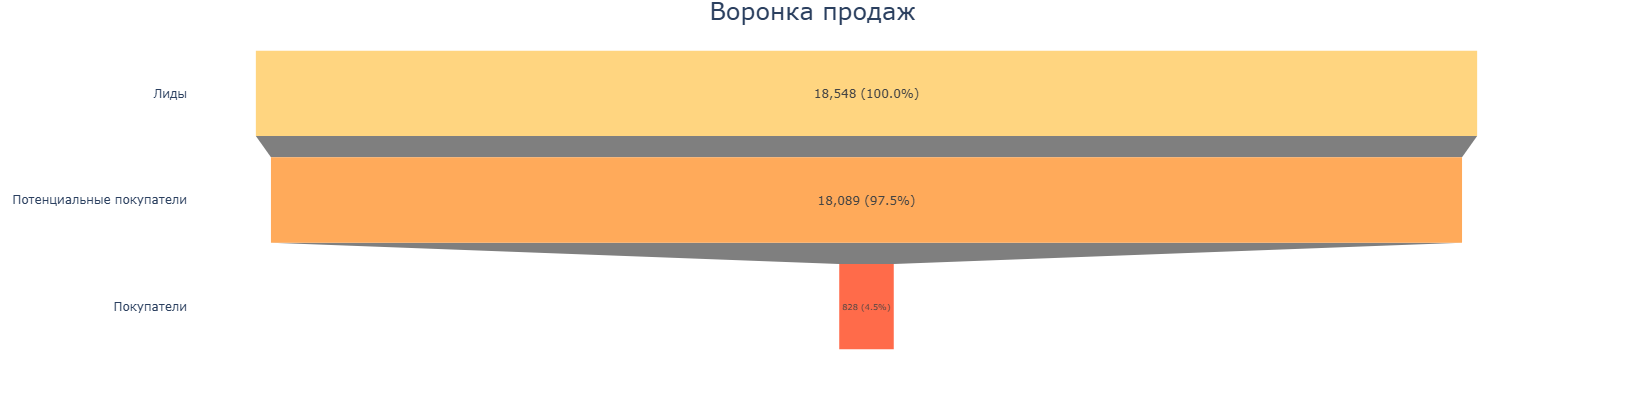

In [3]:
# --- Funnel ---

colors = ["#FFD580", "#FFAA5A", "#FF6B4A"]  # тёпло-жёлтый → оранжевый → кораллово-красный

fig = go.Figure(go.Funnel(
    y=["Лиды", "Потенциальные покупатели", "Покупатели"],
    x=[leads, contact_all_deals, success_contacts],
    textinfo="value+percent initial",
    texttemplate='%{value:,.0f} (%{percentInitial:.1%})',
    marker=dict(color=colors)
))

fig.update_layout(
    title={
        'text': "Воронка продаж",
        'font': {'size': 24},
        'x': 0.5,
        'xanchor': 'center'
    },
    margin=dict(t=40, b=40),
    height=400,
    width=600,
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)'
    
)

fig.show()

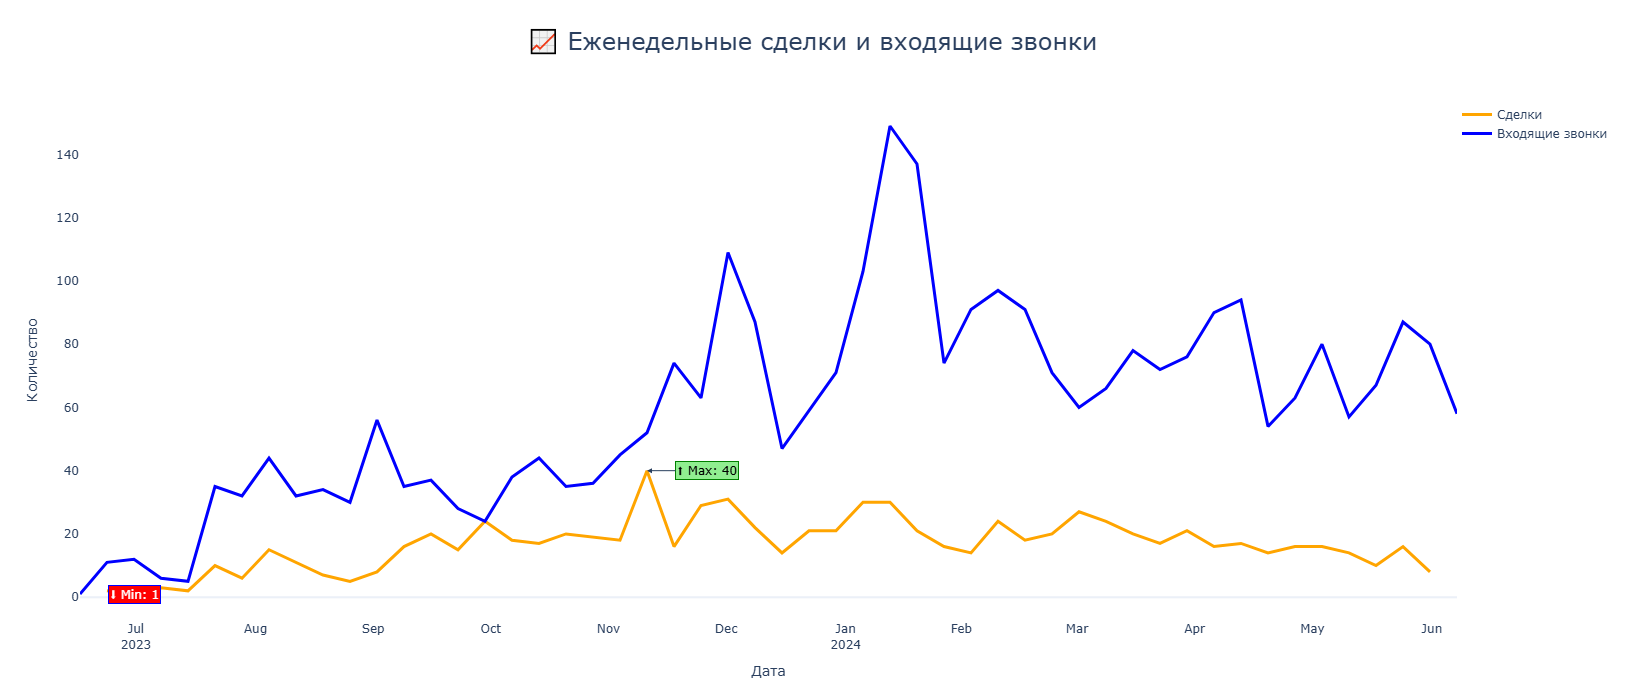

In [4]:
#Graph for presentation

import plotly.graph_objects as go
calls_df = pd.read_pickle("calls_cleaned.pkl")
time_calls_df = calls_df.copy()
time_calls_df.set_index('Call Start Time', inplace=True)

time_success_deals_df = successful_df.copy()
time_success_deals_df.set_index('Created Time', inplace=True)

filtered_calls_df = time_calls_df[
    (time_calls_df['Call Duration Range'] != '0 sec') &
    (time_calls_df['Call Duration Range'] != '1–3 sec')
]
inbound_filtered_calls_df = filtered_calls_df[filtered_calls_df['Call Type'] == 'Inbound']
outbound_filtered_calls_df = filtered_calls_df[filtered_calls_df['Call Type'] == 'Outbound']

weekly_success_deals = time_success_deals_df.resample("W").count()['Id']  # Series
weekly_in_calls = inbound_filtered_calls_df.resample('W').size()

# Данные
plot_min_val = weekly_success_deals.min()
plot_min_date = weekly_success_deals.idxmin()

plot_max_val = weekly_success_deals.max()
plot_max_date = weekly_success_deals.idxmax()

fig = go.Figure()

# Аннотация минимума (слева)
fig.add_annotation(
    x=plot_min_date,
    y=plot_min_val,
    text=f"⬇ Min: {plot_min_val}",
    showarrow=False,
    arrowhead=2,
    ax=-60,
    ay=0,
    bgcolor="red",
    bordercolor="blue",
    font=dict(color="white")
)

# Аннотация максимума (справа)
fig.add_annotation(
    x=plot_max_date,
    y=plot_max_val,
    text=f"⬆ Max: {plot_max_val}",
    showarrow=True,
    arrowhead=2,
    ax=60,
    ay=0,
    bgcolor="lightgreen",
    bordercolor="green",
    font=dict(color="black")
)

# Сделки — яркая линия
fig.add_trace(go.Scatter(
    x=weekly_success_deals.index,
    y=weekly_success_deals.values,
    mode='lines',
    name='Сделки',
    line=dict(color='orange', width=3)
))

# Входящие звонки — другая яркая линия
fig.add_trace(go.Scatter(
    x=weekly_in_calls.index,
    y=weekly_in_calls.values,
    mode='lines',
    name='Входящие звонки',
    line=dict(color='blue', width=3)
))

# Настройки графика
fig.update_layout(
    title={'text':'📈 Еженедельные сделки и входящие звонки', 'font': {'size': 24},
        'x': 0.5,
        'xanchor': 'center'
    },
    xaxis_title='Дата',
    yaxis_title='Количество',
    template='plotly_white',
    hovermode='x unified',
    height=700,
    width=1200,
    xaxis=dict(
        showgrid=False,
        tickformat="%b\n%Y",
        dtick="M1",
        ticklabelmode="period",
        tickangle=0
    ),
    yaxis=dict(showgrid=False),
    legend=dict(
        x=1,
        y=1,
        xanchor='left',
        yanchor='top'
    ),
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)'
)

fig.show()

In [ ]:
# Данные
campaigns = [
    'bbo_de', 'brand_search_eng_de', 'blog2_de', 'web2408_de',
    '02.05.24test_de', '14.11.23wide_webinar_de', '08.06.24wide_webinar_de',
    'gen_analyst_de', '15.07.23b_de', '08.04.24wide_webinar_de'
]
impressions = [3069, 7783, 16100, 9315, 20047, 18128, 20934, 8852, 54268, 126514]
conversion_rate = [4.855002, 2.120005, 1.695652, 1.535158, 0.598593, 0.546117, 0.530238, 0.395391, 0.241395, 0.219739]

# Фигура
fig = go.Figure()

fig.add_trace(go.Bar(
    x=campaigns,
    y=impressions,
    name='Impressions',
    marker_color='rgba(255, 140, 0, 0.7)',
    yaxis='y1',
    text=impressions,
    textposition='auto',
))

fig.add_trace(go.Scatter(
    x=campaigns,
    y=conversion_rate,
    name='Conversion Rate (%)',
    yaxis='y2',
    mode='lines+markers+text',
    marker=dict(color='firebrick', size=10),
    line=dict(color='firebrick', width=2),
    text=[f'{cr:.2f}%' for cr in conversion_rate],
    textposition='top center',
))

fig.update_layout(
    title='Campaign Comparison: Reach and Conversion Rate',
    xaxis=dict(title='Campaign'),
    yaxis=dict(
        title='Impressions (Reach)',
        titlefont=dict(color='orange'),
        tickfont=dict(color='orange')
    ),
    yaxis2=dict(
        title='Conversion Rate (%)',
        overlaying='y',
        side='right',
        titlefont=dict(color='firebrick'),
        tickfont=dict(color='firebrick'),
    ),
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)',
    legend=dict(x=0.01, y=0.99, bgcolor='rgba(255,255,255,0)', borderwidth=0),
    margin=dict(l=40, r=40, t=60, b=100),
)

fig.show()

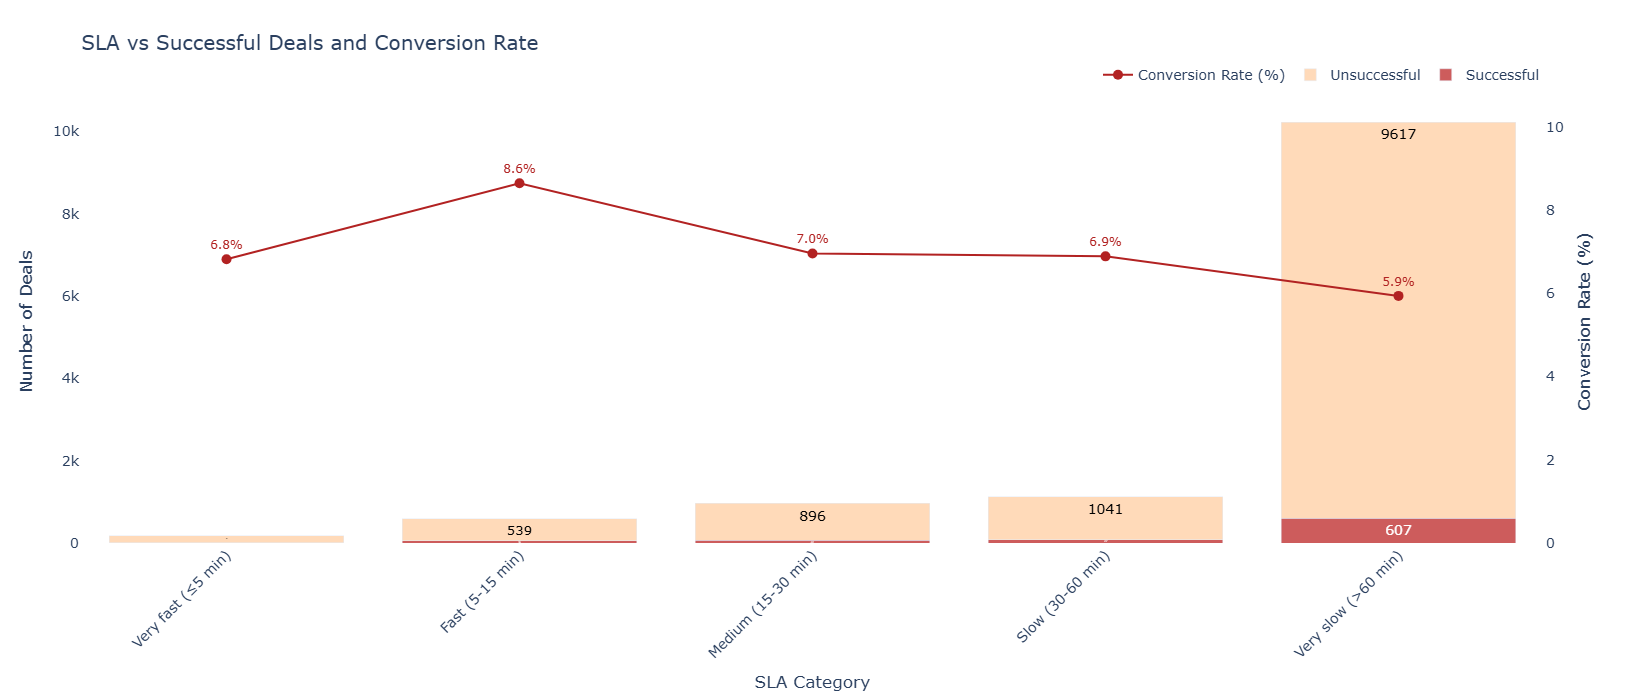

In [28]:
import plotly.express as px
import plotly.graph_objects as go

# Filter deals with non-empty SLA_range
deals_with_sla = deals_df[deals_df['SLA_range'].notna()]

# Separate successful and unsuccessful deals
successful = deals_with_sla[(deals_with_sla['Stage'] == 'Payment Done') & (deals_with_sla['Offer Total Amount'].notna())]
unsuccessful = deals_with_sla[(deals_with_sla['Stage'] != 'Payment Done') & (deals_with_sla['Offer Total Amount'].isna())]

# Group by SLA_range
success_counts = successful['SLA_range'].value_counts().sort_index()
unsuccess_counts = unsuccessful['SLA_range'].value_counts().sort_index()

# Align categories order
sla_categories = [
    'Very fast (≤5 min)',
    'Fast (5-15 min)',
    'Medium (15-30 min)',
    'Slow (30-60 min)',
    'Very slow (>60 min)'
]

success_counts = success_counts.reindex(sla_categories, fill_value=0)
unsuccess_counts = unsuccess_counts.reindex(sla_categories, fill_value=0)

total_counts = success_counts + unsuccess_counts
conversion_rate = (success_counts / total_counts * 100).fillna(0)

fig = go.Figure()

# Успешные
fig.add_trace(go.Bar(
    x=sla_categories,
    y=success_counts,
    name='Successful',
    marker_color='indianred',
    text=success_counts,
    textposition='inside',
    textfont=dict(color='white', size=14)
))

# Неуспешные
fig.add_trace(go.Bar(
    x=sla_categories,
    y=unsuccess_counts,
    name='Unsuccessful',
    marker_color='peachpuff',
    text=unsuccess_counts,
    textposition='inside',
    textfont=dict(color='black', size=14)
))

# Конверсия отдельной линией
fig.add_trace(go.Scatter(
    x=sla_categories,
    y=conversion_rate,
    name='Conversion Rate (%)',
    mode='lines+markers+text',
    yaxis='y2',
    text=[f"{v:.1f}%" for v in conversion_rate],
    textposition='top center',
    textfont=dict(size=12, color='firebrick'),
    marker=dict(color='firebrick', size=10),
    line=dict(color='firebrick', width=2)
))

# Настройки
fig.update_layout(
    title='SLA vs Successful Deals and Conversion Rate',
    barmode='stack',
    xaxis=dict(title='SLA Category', tickangle=-45),
    yaxis=dict(title='Number of Deals'),
    yaxis2=dict(
        title='Conversion Rate (%)',
        overlaying='y',
        side='right',
        range=[0, max(10, conversion_rate.max() + 2)],
        showgrid=False
    ),
    plot_bgcolor='white',
    paper_bgcolor='white',
    height=700,
    font=dict(size=14),
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=1.02,
        xanchor='right',
        x=1
    )
)

fig.show()
